<a href="https://colab.research.google.com/github/regiiis/dlv_group_project/blob/main/dlv_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project

## Set up

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

In [ ]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df

In [29]:
reduced_df=df.sample(frac=0.4,random_state=200)       # random state is a seed value
train_df=reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df=reduced_df.drop(train_df.index)
validation_df=validation_test_df.sample(frac=0.5,random_state=200)
test_df=validation_test_df.drop(validation_df.index)
print(train_df.info())
print()
print(validation_df.info())
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 6015 to 15095
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  6400 non-null   object
 1   anomaly_class   6400 non-null   object
 2   image_name      6400 non-null   object
dtypes: object(3)
memory usage: 200.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 9376 to 1889
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  800 non-null    object
 1   anomaly_class   800 non-null    object
 2   image_name      800 non-null    object
dtypes: object(3)
memory usage: 25.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 18000 to 11514
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  800 non-null    object
 1   

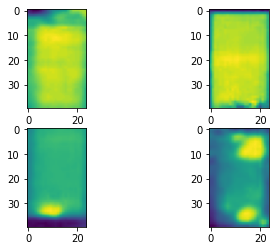

In [8]:
img1 = mpimg.imread('/content/InfraredSolarModules/images/13356.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/8488.jpg')  #Vegetation
img3 = mpimg.imread('/content/InfraredSolarModules/images/8489.jpg')  #Vegetation
img4 = mpimg.imread('/content/InfraredSolarModules/images/7464.jpg')  #Cracking

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)

# Transfer Learning

## Import Model

In [11]:
# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

# Shortcuts to keras if (however from tensorflow)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import layers
from IPython.display import Image

In [ ]:
## The target image size can be fixed here (quadratic)
## The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
#image_size_y = 40
#image_size_x = 32

In [12]:
 conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False)
                                           #input_shape=(image_size_x, image_size_y, 1))

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

*kursiver Text*## Feature extraction without data augmentation

In [18]:
image_height = 40
image_width = 32
batch_size = 64

datagen_train=ImageDataGenerator(rescale=1./255)
datagen_validation=ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

validation_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
     )

Found 160 validated image filenames belonging to 10 classes.
Found 20 validated image filenames belonging to 6 classes.


In [16]:
train_generator

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_generator)
val_features, val_labels = get_features_and_labels(validation_generator)


In [ ]:
inputs = keras.Input(shape=(4, 4, 512))
# Note the use of the Flatten layer before passing the
# features to a Dense layer
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(8, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 2,099,464
Trainable params: 2,099,464
Non-trainable params: 0
_________________________________________________________________


## 2nd **Feature Extraction** without data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_height = 40
image_width = 32
batch_size = 64

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
)

val_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "rgb"
     )

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(
    input_shape=(image_width,image_height,3),
    include_top=False,
    weights="imagenet"
)

for layer in pre_trained_model.layers:
    layer.trainable=False
    
pre_trained_model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

model = tf.keras.models.Sequential([
    pre_trained_model,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

model.summary()

In [ ]:
###2
model.compile(loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])


logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model.fit(
train_generator,
epochs=30,
validation_data=(val_generator),
callbacks=callbacks
)

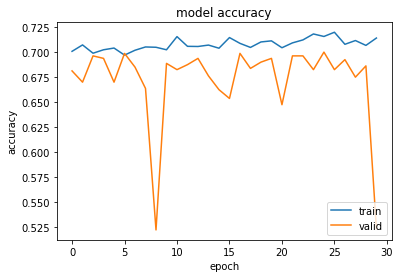

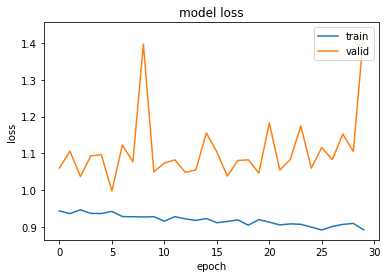

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Make Prediction

In [53]:
predict_datagen = ImageDataGenerator( rescale = 1./255. )

predict_generator =  predict_datagen.flow_from_directory(
                    "../input/seg_pred/",
                    batch_size=128, 
                    class_mode=None,
                    shuffle=False,
                    target_size=(image_width, image_height)
)

FileNotFoundError: ignored

In [ ]:
pred = model.predict_generator(predict_generator,verbose=1)

In [ ]:
import numpy as np
predicted_class_indices=np.argmax(pred,axis=1)

### Train Model

In [ ]:
model.compile(loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])


logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]




NameError: ignored

In [ ]:
history = model.fit(
train_generator,
epochs=30,
validation_data = validation_generator,
callbacks=callbacks)


Epoch 1/30


InvalidArgumentError: ignored

#### Model Performance

In [ ]:
# Epoch Statistics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
# Validate Model
model.evaluate(val_features, val_labels)

#### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension on google colab
%load_ext tensorboard

%tensorboard --logdir logs